# Testing Model

> **Note**: Please save the model first before proceeding with this notebook. [Run this notebook](./save_model.ipynb)

In [1]:
import os
import warnings
from typing import Iterable, Literal

import librosa
import matplotlib.pyplot as plt
import numpy as np
import torch
from pydub import AudioSegment
from transformers import AutoModelForCTC, AutoProcessor

warnings.simplefilter("ignore")

Matplotlib is building the font cache; this may take a moment.


## Loading model

In [2]:
MODEL_PATH = "./pretrained"


def get_model_and_processor() -> tuple:
    """
    Loads model and processor from local directory
    Returns tuple of (model, processor)
    """
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(f"Model directory not found at {MODEL_PATH}")

    global model, processor
    if "processor" not in globals():
        processor = AutoProcessor.from_pretrained(
            MODEL_PATH,
            local_files_only=True,  # ensures no attempts to download from hub
        )
    if "model" not in globals():
        model = AutoModelForCTC.from_pretrained(
            MODEL_PATH, local_files_only=True
        )
    return model, processor

## Defining Teacher & Student audios path

In [35]:
inpath: str = os.path.abspath("../../../frontend/assets/audio")
outpath: str = os.path.abspath("../../uploads")

samples_in: tuple[str, ...] = tuple(
    sorted([os.path.join(inpath, file) for file in os.listdir(inpath)])
)
samples_out: tuple[str, ...] = tuple(
    sorted(
        [
            os.path.join(outpath, file)
            for file in os.listdir(outpath)
            if not file.startswith(".")
        ]
    )
)

## ~~Function to load audio using `pydub` library~~
> **Note**: Switched to `librosa` library, while filtering the m4a warnings. [See this](#comparing-pydub-and-librosa-accuracy)

In [36]:
# def load_audio(audio_file: str, target_sr: int = 16000) -> np.ndarray:
#     """
#     Load audio file using pydub and convert to the format needed by the model.

#     Args:
#         audio_file: Path to the audio file
#         target_sr: Target sample rate in Hz

#     Returns:
#         numpy array of audio samples normalized to [-1, 1]
#     """
#     audio = AudioSegment.from_file(audio_file)

#     # convert to mono and set sample rate
#     audio = audio.set_frame_rate(target_sr).set_channels(1)

#     # convert to numpy array and normalize
#     samples = np.array(audio.get_array_of_samples(), dtype=np.float32)
#     samples = samples / 32768.0  # normalize to [-1, 1]

#     return samples

In [37]:
model, processor = get_model_and_processor()

In [38]:
if "_cache" not in globals():
    _cache = {}


def transcribe_audio(model, processor, *, audio_file) -> str:
    """Function to transcribe audio and return the letter said"""
    if audio_file in _cache:
        return _cache[audio_file]

    if not os.path.exists(audio_file):
        raise FileNotFoundError(f"Audio file {audio_file} not found.")

    speech, _ = librosa.load(audio_file, sr=16000)
    # Use pydub instead of librosa
    # speech = load_audio(audio_file, target_sr=16000)

    input_values = processor(
        speech, return_tensors="pt", sampling_rate=16000
    ).input_values

    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)[0]

    letter = transcription.strip()
    if not letter:
        raise Exception("Failed to transcribe the audio.")

    _cache[audio_file] = letter

    return letter


def transcribe_audios(
    model,
    processor,
    *,
    audio_files: str | Iterable[str] | None = None,
    with_filepath: bool = False,
    with_filename: bool = False,
    sample: Literal["in", "out"] | None = None,
) -> list[str | tuple[str, ...]]:

    if with_filename and with_filepath:
        raise ValueError(
            "Parameter `filepath` cannot be set to `True` while `filename` is "
            "set to `True` choose either."
        )

    if audio_files and sample:
        raise ValueError("You can only use `audio_files` or `sample` not both")

    def parse_sample(s: str | None) -> tuple[str, ...] | None:
        if not s:
            return None

        dc: dict[str, tuple[str, ...]] = {"in": samples_in, "out": samples_out}
        return dc[s]

    def parse_fname(s: str) -> str:
        if with_filename:
            return os.path.basename(s)
        return s

    def parse_tup(f: str, s: str) -> str | tuple[str, ...]:
        if with_filepath or with_filename:
            return (parse_fname(f), s)

        return s

    files = audio_files or parse_sample(sample)
    assert files, "Parameter `audio_files` or `sample` must be properly set"

    if isinstance(files, str):
        files = [files]

    def parse_all(f: str, s: str) -> str | tuple[str, ...]:
        return parse_tup(f, s)

    return [
        parse_all(f, transcribe_audio(model, processor, audio_file=f))
        for f in files
    ]

## Example usage of `transcribe_audios` *function*.

In [ ]:
# ============================================================================== #
# Using a sample                                                                 #
# output full file path + model prediction                                       #
# ============================================================================== #
# print(transcribe_audios(model, processor, sample="in", with_filepath=True))
# print(transcribe_audios(model, processor, sample="out", with_filepath=True))

# ============================================================================== #
# output file name only + model prediction                                       #
# ============================================================================== #
print(transcribe_audios(model, processor, sample="in", with_filename=True))
print(transcribe_audios(model, processor, sample="out", with_filename=True))

# ============================================================================== #
# pass a tuple of filepaths                                                      #
# ============================================================================== #
# print(transcribe_audios(model, processor, audio_files=samples_in, with_filename=True))
# print(transcribe_audios(model, processor, audio_files=samples_out, with_filename=True))


# ============================================================================== #
# pass one file path only                                                        #
# ============================================================================== #
# print(transcribe_audios(model, processor, audio_files=samples_in[0], with_filename=True))
# print(transcribe_audios(model, processor, audio_files=samples_out[0], with_filename=True))

[('kaf.mp3', 'ك'), ('ra.mp3', 'أروء'), ('shiin.mp3', 'بسين'), ('siin.mp3', 'سيين')]
[('kafOut.mp3', 'كف'), ('raOut.mp3', 'أرا'), ('shiinOut.mp3', 'لنم'), ('siinOut.mp3', 'صرن')]


## Comparing `pydub` and `librosa` accuracy

=== Audio Statistics ===
Librosa shape: (23406,)
Pydub shape: (23406,)
Librosa range: [-0.182, 0.146]
Pydub range: [-0.182, 0.146]

=== Model Predictions ===

Librosa Input Values:
Shape: torch.Size([1, 23406])
Range: [-4.721, 3.773]
Prediction: لنم

Pydub Input Values:
Shape: torch.Size([1, 23406])
Range: [-4.708, 3.776]
Prediction: لم


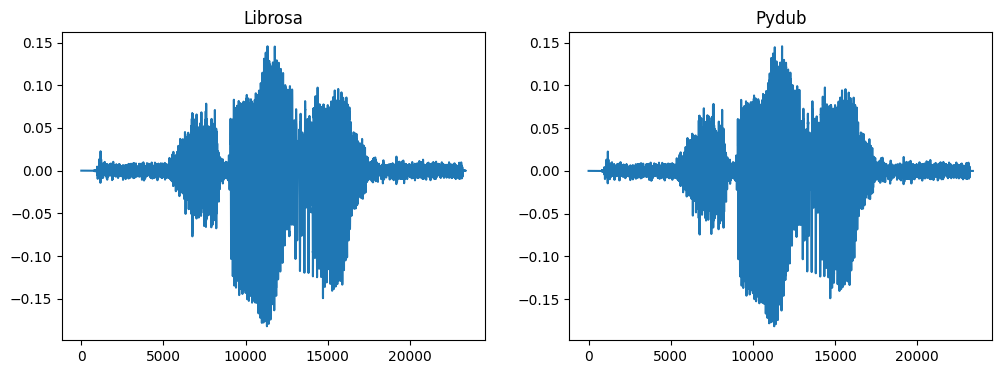

In [ ]:
def debug_audio_pipeline(audio_path: str):
    """Compare librosa vs pydub processing with detailed debug info"""

    # load with librosa
    lib_audio, _ = librosa.load(audio_path, sr=16000, mono=True)

    # load with pydub
    audio = AudioSegment.from_file(audio_path)
    audio = audio.set_frame_rate(16000).set_channels(1)
    pydub_audio = (
        np.array(audio.get_array_of_samples(), dtype=np.float32) / 32768.0
    )

    # debug statistics
    print("=== Audio Statistics ===")
    print(f"Librosa shape: {lib_audio.shape}")
    print(f"Pydub shape: {pydub_audio.shape}")
    print(f"Librosa range: [{lib_audio.min():.3f}, {lib_audio.max():.3f}]")
    print(f"Pydub range: [{pydub_audio.min():.3f}, {pydub_audio.max():.3f}]")

    # process both through model
    print("\n=== Model Predictions ===")
    for name, audio_data in [("Librosa", lib_audio), ("Pydub", pydub_audio)]:
        input_values = processor(
            audio_data, return_tensors="pt", sampling_rate=16000, padding=True
        ).input_values

        print(f"\n{name} Input Values:")
        print(f"Shape: {input_values.shape}")
        print(f"Range: [{input_values.min():.3f}, {input_values.max():.3f}]")

        with torch.no_grad():
            logits = model(input_values).logits
            predicted_ids = torch.argmax(logits, dim=-1)
            transcription = processor.batch_decode(predicted_ids)[0]

        print(f"Prediction: {transcription}")

    # Plot waveforms
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(lib_audio)
    plt.title("Librosa")
    plt.subplot(122)
    plt.plot(pydub_audio)
    plt.title("Pydub")
    plt.show()


audio_path = samples_out[2]
debug_audio_pipeline(audio_path)